<a href="https://colab.research.google.com/github/srujannayak32/MLLAB189/blob/main/ML_INTERNAL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#1Q
# === Filter Methods example (Titanic: classification) ===
import pandas as pd, numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

# Load (change path to your location in Colab)
titanic = pd.read_csv("/content/drive/MyDrive/MLLAB DATASETS/titanic_train.csv")  # replace with path

# Quick cleanup: drop too-sparse cols and fill missing
titanic = titanic.loc[:, titanic.isnull().mean() < 0.5]
for c in titanic.select_dtypes(include=[object]).columns:
    titanic[c] = titanic[c].fillna("missing")
for c in titanic.select_dtypes(include=[np.number]).columns:
    titanic[c] = titanic[c].fillna(titanic[c].median())

# Encode categoricals
le = LabelEncoder()
for c in titanic.select_dtypes(exclude=[np.number]).columns:
    titanic[c] = le.fit_transform(titanic[c].astype(str))

# Prepare X,y (example uses "Survived")
y = titanic['Survived']
X = titanic.drop(columns=['Survived','PassengerId','Name','Ticket','Cabin'], errors='ignore')

# 1.1 Constant features
const_feats = [c for c in X.columns if X[c].nunique()==1]

# 1.2 Quasi-constant (dominant value > 99%)
quasi_feats = [c for c in X.columns if X[c].value_counts(normalize=True).iloc[0] > 0.99]

# 1.3 Duplicate features
dup_pairs = []
cols = X.columns.tolist()
for i,c1 in enumerate(cols):
    for c2 in cols[i+1:]:
        if X[c1].equals(X[c2]):
            dup_pairs.append((c1,c2))

# 1.4 Correlation pairs (absolute > 0.8)
corr = X.corr().abs()
high_corr = [(corr.columns[i], corr.columns[j], corr.iloc[i,j])
             for i in range(len(corr)) for j in range(i+1,len(corr)) if corr.iloc[i,j] > 0.8]

# 1.5 Mutual Information (classification)
mi = mutual_info_classif(X.fillna(0), y)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# 1.6 Chi-square (works with non-negative ints)
chi_sel = SelectKBest(score_func=chi2, k='all').fit(X.fillna(0).astype(int), y)
chi_scores = pd.Series(chi_sel.scores_, index=X.columns).sort_values(ascending=False)

# 1.7 ANOVA f-test
f_sel = SelectKBest(score_func=f_classif, k='all').fit(X.fillna(0), y)
f_scores = pd.Series(f_sel.scores_, index=X.columns).sort_values(ascending=False)

# 1.8 Univariate ROC-AUC per feature
auc_scores = {}
for c in X.columns:
    try:
        auc_scores[c] = roc_auc_score(y, X[c])
    except Exception:
        auc_scores[c] = np.nan
auc_series = pd.Series(auc_scores).sort_values(ascending=False)

# Print concise results
print("Constant features:", const_feats)
print("Quasi-constant features:", quasi_feats)
print("Top MI features:\n", mi_scores.head())
print("Top Chi2 features:\n", chi_scores.head())
print("Top ANOVA features:\n", f_scores.head())
print("Top per-feature ROC-AUC:\n", auc_series.head())


Constant features: []
Quasi-constant features: []
Top MI features:
 Sex       0.159322
Fare      0.147076
Pclass    0.067524
SibSp     0.034762
Parch     0.015783
dtype: float64
Top Chi2 features:
 Fare      4585.962421
Sex         92.702447
Pclass      30.873699
Age         21.688248
Parch       10.097499
dtype: float64
Top ANOVA features:
 Sex         372.405724
Pclass      115.031272
Fare         63.030764
Embarked     24.422821
Parch         5.963464
dtype: float64
Top per-feature ROC-AUC:
 Fare        0.692122
Parch       0.561217
SibSp       0.543162
Age         0.478166
Embarked    0.427913
dtype: float64


In [ ]:
#2Q
#Forward Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/titanic_train.csv')
target='Survived'
X_train=df[df.select_dtypes(include=['number']).columns].drop(columns=[target]).fillna(0)
Y_train=df[target]

model= LogisticRegression(max_iter=1000)

sfs = SFS(model,k_features=5,forward=True,floating=False,scoring='accuracy',cv=5)

sfs.fit(X_train,Y_train)

print("Selected features: ",sfs.k_feature_names_)
print("CV Accuracy score:", sfs.k_score_)

Selected features:  ('PassengerId', 'Pclass', 'Age', 'Parch', 'Fare')
CV Accuracy score: 0.7049023915636181


In [ ]:
#Backward Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/house_price_train.csv')
target='SalePrice'
X_train=df[df.select_dtypes(include=['number']).columns].drop(columns=[target]).fillna(0)
Y_train=df[target]

model= LinearRegression()

sfs = SFS(model,k_features=5,forward=False,floating=False,scoring='r2',cv=5)

sfs.fit(X_train,Y_train)

print("Selected features: ",sfs.k_feature_names_)
print("CV Accuracy score:", sfs.k_score_)

Selected features:  ('MSSubClass', 'OverallQual', 'YearBuilt', 'GrLivArea', 'BsmtFullBath')
CV Accuracy score: 0.768976918373802


In [ ]:
#Exhaustive Search
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LogisticRegression
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/titanic_train.csv')
target='Survived'
X_train=df[df.select_dtypes(include=['number']).columns].drop(columns=[target]).fillna(0)
Y_train=df[target]

model= LogisticRegression(max_iter=1000)

efs = EFS(model,max_features=5,min_features=2,scoring='accuracy',cv=5)

efs.fit(X_train,Y_train)

print("Selected features: ",efs.best_feature_names_)
print("CV Accuracy score:", efs.best_score_)

Features: 56/56

Selected features:  ('Pclass', 'Age', 'Parch', 'Fare')
CV Accuracy score: 0.7049023915636181


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
est = RandomForestClassifier(n_estimators=100, random_state=0)
rfe = RFE(estimator=est, n_features_to_select=5)  # choose number
rfe.fit(X, y)
selected = X.columns[rfe.support_]
print("RFE selected:", list(selected))

RFE selected: ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']


In [ ]:
#3Q
# Lasso / Ridge / ElasticNet example (regression)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler

df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/house_price_train.csv')
target='SalePrice'
X_reg=df[df.select_dtypes(include=['number']).columns].drop(columns=[target]).fillna(0)
y_reg=df[target]

# X_reg, y_reg are numeric features and target
scaler = StandardScaler()
Xs = scaler.fit_transform(X_reg)

lasso = LassoCV(cv=5).fit(Xs, y_reg)
ridge = RidgeCV(cv=5).fit(Xs, y_reg)
enet = ElasticNetCV(cv=5).fit(Xs, y_reg)

print("Lasso non-zero coef count:", (lasso.coef_ != 0).sum())
print("Ridge coefficients (not sparse):", ridge.coef_[:5])
print("ElasticNet non-zero count:", (enet.coef_ != 0).sum())

# Random Forest importances
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_reg, y_reg)
importances = pd.Series(rf.feature_importances_, index=X_reg.columns).sort_values(ascending=False)
print("RF top features:\n", importances.head())


Lasso non-zero coef count: 27
Ridge coefficients (not sparse): [ -447.08348215 -6935.91748947   345.85254107  3884.6825475
 23664.26091501]
ElasticNet non-zero count: 37
RF top features:
 OverallQual    0.585420
GrLivArea      0.114281
TotalBsmtSF    0.045547
2ndFlrSF       0.035330
BsmtFinSF1     0.028632
dtype: float64


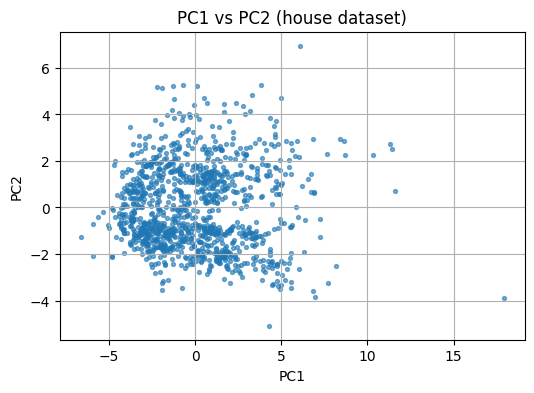

PC1 top variables:
 SalePrice      0.308500
OverallQual    0.288091
GrLivArea      0.276981
GarageCars     0.268339
GarageArea     0.263238
Name: 0, dtype: float64
PC2 top variables:
 2ndFlrSF        0.458484
BedroomAbvGr    0.367765
TotRmsAbvGrd    0.330391
GrLivArea       0.269651
BsmtFullBath    0.253607
Name: 1, dtype: float64
Explained variance ratio (PC1, PC2): [0.2163204  0.08313725]
Cumulative explained variance: [0.2163204  0.29945766 0.37067359 0.42443509 0.46484174 0.49795751
 0.53014382 0.56017111 0.59005016 0.61915556]
PCs needed to explain >80% variance: 11


In [ ]:
#4Q
# PCA example (house dataset)
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/MLLAB DATASETS/house_price_train.csv")  # replace path
# keep numeric columns only and drop rows with NA for simplicity
num = df.select_dtypes(include='number').dropna(axis=0)
# Target removal if present
num = num.loc[:, num.nunique() > 1]  # remove constant cols

X = num.drop(columns=[c for c in num.columns if c.lower() in ['price','saleprice']][:0], errors='ignore')

# a) Standardize
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# b) PCA
pca = PCA(n_components=min(10, Xs.shape[1]))
Xp = pca.fit_transform(Xs)

# scatter plot PC1 vs PC2
plt.figure(figsize=(6,4))
plt.scatter(Xp[:,0], Xp[:,1], alpha=0.6, s=8)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PC1 vs PC2 (house dataset)")
plt.grid(True)
plt.show()

# c) Most important variables for PC1 and PC2
components = pd.DataFrame(pca.components_, columns=X.columns)
pc1_top = components.iloc[0].abs().sort_values(ascending=False).head(5)
pc2_top = components.iloc[1].abs().sort_values(ascending=False).head(5)
print("PC1 top variables:\n", pc1_top)
print("PC2 top variables:\n", pc2_top)

# d) variance explained
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2])
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())

# e) Number of PCs to explain > 80%
n_80 = (pca.explained_variance_ratio_.cumsum() < 0.8).sum() + 1
print("PCs needed to explain >80% variance:", n_80)


In [ ]:
#5Q
#Simple Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/house_price_train.csv')
X=df[['BedroomAbvGr']]
Y=df['SalePrice']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)


model=LinearRegression()

model.fit(X_train,Y_train)

y_pred=model.predict(X_test)

y=pd.DataFrame({"Bedrooms":X_test.values.ravel(),"Y Pred":y_pred.round(1),"Y test":Y_test})
print(y)
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])
print("MSE:", mean_squared_error(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred)))

      Bedrooms    Y Pred  Y test
892          3  182989.3  154500
1105         3  182989.3  325000
413          2  167690.1  115000
522          3  182989.3  159000
1036         2  167690.1  315500
...        ...       ...     ...
331          3  182989.3  139000
323          3  182989.3  126175
650          3  182989.3  205950
439          3  182989.3  110000
798          4  198288.5  485000

[438 rows x 3 columns]
Intercept: 137091.7873370002
Slope: 15299.175809609273
MSE: 6745999805.905119
MAE: 57936.87444721576
RMSE: 82134.0356119503


In [ ]:
#6Q
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/Salary_Data.csv')
X=df[['Years of Experience']]
Y=df['Salary']

# Handle missing values in X using mean imputation
X = X.fillna(X.mean())
# Handle missing values in Y using mean imputation
Y = Y.fillna(Y.mean())


X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)


model=LinearRegression()

model.fit(X_train,Y_train)

y_pred=model.predict(X_test)

y=pd.DataFrame({"Years of Experience":X_test.values.ravel(),"Y Pred":y_pred.round(1),"Y test":Y_test})
print(y)
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])
print("MSE:", mean_squared_error(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred)))

      Years of Experience    Y Pred    Y test
2794                 19.0  192634.5  156486.0
2233                  8.0  114754.5  140000.0
5559                  3.0   79354.5   80000.0
6355                  2.0   72274.5   40000.0
263                   3.0   79354.5   50000.0
...                   ...       ...       ...
2820                 32.0  284674.4  195270.0
3165                  8.0  114754.5  100000.0
5947                  0.0   58114.5   25000.0
6429                  3.0   79354.5   50000.0
2291                  2.0   72274.5   60000.0

[2012 rows x 3 columns]
Intercept: 58114.51783420503
Slope: 7079.997718146921
MSE: 968357549.387374
MAE: 25025.993631288096
RMSE: 31118.443877986156


In [ ]:
#7Q
#MultiLinear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/house_price_train.csv')
X=df[['BedroomAbvGr','YearBuilt','LotArea']]
Y=df['SalePrice']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)


model=LinearRegression()

model.fit(X_train,Y_train)

y_pred=model.predict(X_test)

y=pd.DataFrame({"Bedrooms":X_test['BedroomAbvGr'],"Year_Built":X_test['YearBuilt'],"Lot_Area":X_test['LotArea'],"Y Pred":y_pred.round(1),"Y test":Y_test})
print(y)

print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])
print("MSE:", mean_squared_error(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred)))

      Bedrooms  Year_Built  Lot_Area    Y Pred  Y test
892          3        1963      8414  168771.1  154500
1105         3        1994     12256  216356.6  325000
413          2        1927      8960  104174.0  115000
522          3        1947      5000  141875.4  159000
1036         2        2007     12898  217221.4  315500
...        ...         ...       ...       ...     ...
331          3        1958      8176  161718.9  139000
323          3        1955      5820  153875.7  126175
650          3        2007      8125  226940.8  205950
439          3        1920     12354  117892.5  110000
798          4        2008     13518  254583.6  485000

[438 rows x 5 columns]
Intercept: -2513690.8423875435
Slope: 17508.82401069071
MSE: 4319149517.348582
MAE: 43617.12686240664
RMSE: 65720.23674142221


In [ ]:
#8Q
#Polynomial Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/house_price_train.csv')
X=df[['BedroomAbvGr','YearBuilt','LotArea']]
Y=df['SalePrice']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
poly=PolynomialFeatures(degree=2)

X_poly_train=poly.fit_transform(X_train)
X_poly_test=poly.transform(X_test)
model=LinearRegression()

model.fit(X_poly_train,Y_train)

y_pred=model.predict(X_poly_test)

y=pd.DataFrame({"Bedrooms":X_test['BedroomAbvGr'],"Year_Built":X_test['YearBuilt'],"Lot_Area":X_test['LotArea'],"Y Pred":y_pred.round(1),"Y test":Y_test})
print(y)
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])
print("MSE:", mean_squared_error(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred)))

      Bedrooms  Year_Built  Lot_Area    Y Pred  Y test
892          3        1963      8414  139228.3  154500
1105         3        1994     12256  221259.4  325000
413          2        1927      8960  113801.8  115000
522          3        1947      5000  107788.5  159000
1036         2        2007     12898  253216.6  315500
...        ...         ...       ...       ...     ...
331          3        1958      8176  131874.6  139000
323          3        1955      5820  117967.4  126175
650          3        2007      8125  240742.1  205950
439          3        1920     12354  137267.4  110000
798          4        2008     13518  288802.8  485000

[438 rows x 5 columns]
Intercept: 83128744.08543923
Slope: 0.0
MSE: 3480648181.1418314
MAE: 38261.59247550984
RMSE: 58997.018408914795


In [ ]:
#9Q
#LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

df=pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/diabetes_DT.csv')
target="Outcome"
X=df.drop(columns=[target])
Y=df[target]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

model=LogisticRegression(max_iter=1000)

model.fit(X_train,Y_train)

y_pred= model.predict(X_test)

print("Accuracy: ", accuracy_score(Y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,y_pred))

# Calculate and print precision, recall, and f1-score
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy:  0.7359307359307359
Confusion Matrix:
 [[120  31]
 [ 30  50]]
Precision: 0.6172839506172839
Recall: 0.625
F1: 0.6211180124223602


In [ ]:
#10Q
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

learning_rates = [0.0001, 0.001, 0.01, 0.1]
epochs = [100, 500, 1000]
results = []

for lr in learning_rates:
    for epoch in epochs:
        model = SGDRegressor(max_iter=epoch, eta0=lr, learning_rate='constant', random_state=42)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results.append((lr, epoch, rmse, r2))
        print(f"Learning Rate: {lr}, Epochs: {epoch} --> RMSE: {rmse:.2f}, R2: {r2:.4f}")

# Find the best configuration
best = min(results, key=lambda x: x[2])  # minimizing RMSE
print("\nBest configuration:")
print(f"Learning Rate: {best[0]}, Epochs: {best[1]} --> RMSE: {best[2]:.2f}, R2: {best[3]:.4f}")

Learning Rate: 0.0001, Epochs: 100 --> RMSE: 0.43, R2: 0.1991
Learning Rate: 0.0001, Epochs: 500 --> RMSE: 0.43, R2: 0.1991
Learning Rate: 0.0001, Epochs: 1000 --> RMSE: 0.43, R2: 0.1991
Learning Rate: 0.001, Epochs: 100 --> RMSE: 0.42, R2: 0.2178
Learning Rate: 0.001, Epochs: 500 --> RMSE: 0.42, R2: 0.2178
Learning Rate: 0.001, Epochs: 1000 --> RMSE: 0.42, R2: 0.2178
Learning Rate: 0.01, Epochs: 100 --> RMSE: 0.43, R2: 0.1953
Learning Rate: 0.01, Epochs: 500 --> RMSE: 0.43, R2: 0.1953
Learning Rate: 0.01, Epochs: 1000 --> RMSE: 0.43, R2: 0.1953
Learning Rate: 0.1, Epochs: 100 --> RMSE: 0.66, R2: -0.9025
Learning Rate: 0.1, Epochs: 500 --> RMSE: 0.66, R2: -0.9025
Learning Rate: 0.1, Epochs: 1000 --> RMSE: 0.66, R2: -0.9025

Best configuration:
Learning Rate: 0.001, Epochs: 100 --> RMSE: 0.42, R2: 0.2178


In [ ]:
import numpy as np

y_train_log = np.log1p(y_train)

final_model_log = SGDRegressor(max_iter=1000, eta0=0.0001, random_state=42, learning_rate='constant')

final_model_log.fit(X_train_scaled, y_train_log)

y_pred_log = final_model_log.predict(X_test_scaled)
y_pred_final = np.expm1(y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
print(f"New RMSE after log transform: {rmse:.2f}")

New RMSE after log transform: 0.45


In [ ]:
#11Q
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('/content/drive/MyDrive/MLLAB DATASETS/diabetes_DT.csv')
target = "Outcome"
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Polynomial features (non-linear transformation)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Ridge and Lasso models
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1, max_iter=10000)  # increase max_iter for convergence

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)

# Mean Squared Errors
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Coefficients
ridge_coefs = ridge.coef_
lasso_coefs = lasso.coef_

# Display results
print("Ridge MSE:", mse_ridge)
print("Lasso MSE:", mse_lasso)
print("\nRidge Coefficients:\n", ridge_coefs)
print("\nLasso Coefficients:\n", lasso_coefs)

# Count non-zero coefficients (important for Lasso feature selection)
print("\nNumber of non-zero coefficients in Ridge:", np.sum(ridge_coefs != 0))
print("Number of non-zero coefficients in Lasso:", np.sum(lasso_coefs != 0))

Ridge MSE: 0.17914232053118123
Lasso MSE: 0.18376494280117595

Ridge Coefficients:
 [ 0.          0.18771856  0.00190198  0.05561853 -0.03306781 -0.22603325
 -0.01822302  0.22071459  0.26496902  0.06374377 -0.13857083 -0.0553769
  0.03232109  0.01088846  0.04936374  0.03646423 -0.20734966  0.36484509
 -0.02510987 -0.07745086 -0.14462315 -0.01139866 -0.02779834 -0.09741911
 -0.06044246  0.08921654  0.12403198 -0.13111944 -0.1477909   0.2169376
 -0.02886487  0.08679604 -0.04304226  0.13175844 -0.02983001  0.01317152
  0.01746816 -0.03081681  0.14706167  0.17630692  0.00419461  0.03727227
 -0.14323672 -0.00517716 -0.27110903]

Lasso Coefficients:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.07298256
 0.         0.         0.         0.06945679 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

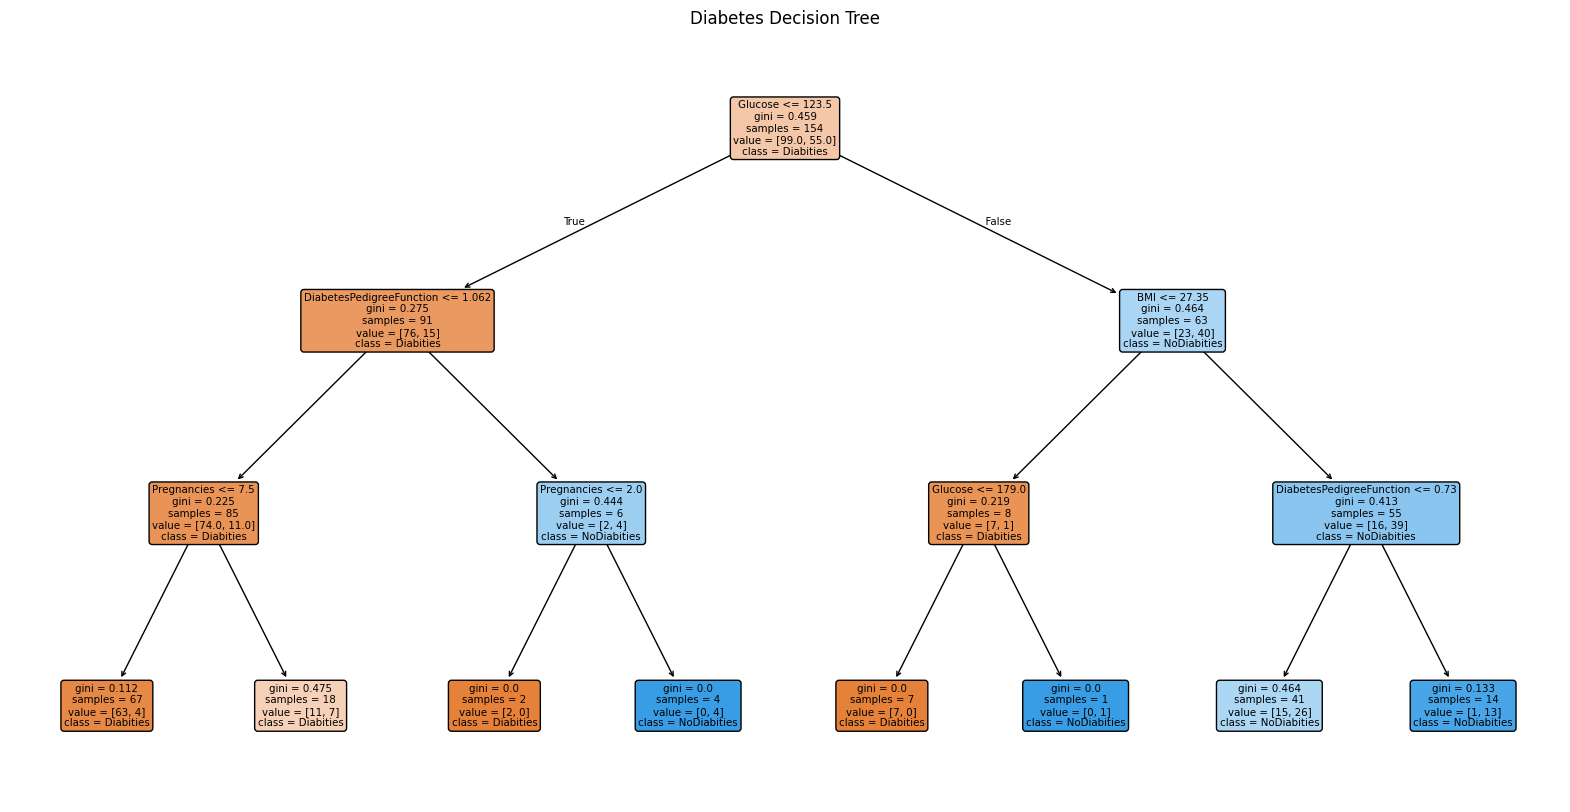

In [ ]:
#12Q
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
import matplotlib.pyplot as plt

df=pd.read_csv("/content/drive/MyDrive/MLLAB DATASETS/diabetes_DT.csv")

X=df.iloc[:,:-1]
y=df.iloc[:,-1]

X_test,X_train,y_test,y_train = train_test_split(X,y,test_size=0.2,random_state=42)

dt=DecisionTreeClassifier(max_depth=3,random_state=42)
dt.fit(X_train,y_train)

plt.figure(figsize=(20,10))
plot_tree(dt,
          feature_names=X.columns,
          class_names=["Diabities","NoDiabities"],
          filled=True,
          rounded=True
          )

plt.title("Diabetes Decision Tree")
plt.savefig("decision_tree.png")
plt.show()

In [ ]:
#13Q
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("/content/drive/MyDrive/MLLAB DATASETS/loan_data_set.csv")
le=LabelEncoder()
for col in df.columns:
  if df[col].dtype==object:
    df[col]=le.fit_transform(df[col])

# Fill missing values with the mode before converting to int
for col in df.columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])


print(df.columns)

X=df.drop("Loan_Status",axis=1).astype(int)
y=df["Loan_Status"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=GaussianNB()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Accuracy: 0.7886178861788617


In [ ]:
#14Q
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

df=pd.read_csv("/content/drive/MyDrive/MLLAB DATASETS/breast-cancer.csv")
le=LabelEncoder()

if "id" in df.columns:
  df = df.drop("id",axis=1)

if "diagnosis" in df.columns:
  df['diagnosis']=le.fit_transform(df['diagnosis'])

X=df.drop("diagnosis",axis=1)
y=df["diagnosis"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=SVC()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 94.74%


In [ ]:
#15Q
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy: {accuracy:.2%}")

KNN Model Accuracy: 100.00%
